## Import de librerías necesarias

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE 
from xgboost import XGBClassifier
import lightgbm as lgb
import joblib
import os
from tqdm import tqdm
import pickle
from tqdm_joblib import tqdm_joblib
df = pd.read_csv('../data/processed/data_processed.csv') # Carga el df ya limpio

In [13]:
import re

def limpiar_nombres_columnas(columnas):
    """
    Limpia una lista de nombres de columnas:
    - Elimina espacios iniciales y finales
    - Reemplaza espacios internos por guiones bajos
    - Convierte a minúsculas
    - Elimina caracteres especiales (excepto letras, números y guiones bajos)
    """
    columnas_limpias = []
    for col in columnas:
        col = col.strip()  # elimina espacios iniciales/finales
        col = col.lower()  # a minúsculas
        col = col.replace(' ', '_')  # espacios a guiones bajos
        col = re.sub(r'[^a-z0-9_]', '', col)  # elimina caracteres especiales
        columnas_limpias.append(col)
    return columnas_limpias


In [14]:
df.columns = limpiar_nombres_columnas(df.columns)


In [15]:
df.columns

Index(['bankrupt', 'roaa_before_interest_and_percent_after_tax',
       'operating_gross_margin', 'after_tax_net_interest_rate',
       'non_industry_income_and_expenditure_revenue', 'operating_expense_rate',
       'research_and_development_expense_rate', 'cash_flow_rate',
       'interest_bearing_debt_interest_rate', 'tax_rate_a',
       'net_value_per_share_a', 'cash_flow_per_share',
       'revenue_per_share_yuan', 'realized_sales_gross_profit_growth_rate',
       'operating_profit_growth_rate', 'regular_net_profit_growth_rate',
       'continuous_net_profit_growth_rate', 'total_asset_growth_rate',
       'net_value_growth_rate', 'total_asset_return_growth_rate_ratio',
       'cash_reinvestment_percent', 'current_ratio', 'quick_ratio',
       'interest_expense_ratio', 'total_debt_total_net_worth',
       'debt_ratio_percent', 'long_term_fund_suitability_ratio_a',
       'contingent_liabilities_net_worth',
       'net_profit_before_tax_paid_in_capital',
       'inventory_and_account

## Definición de x,y

In [16]:
X = df.drop(columns=["bankrupt"])
y = df["bankrupt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

In [58]:
# Guardar en data/train y data/test
X_train.to_csv('../data/train/X_train.csv', index=False)
y_train.to_csv('../data/train/y_train.csv', index=False)
X_test.to_csv('../data/test/X_test.csv', index=False)
y_test.to_csv('../data/test/y_test.csv', index=False)

## Random Forest

In [59]:
print("--- Estrategia: RandomForest con class_weight='balanced' (sin SMOTE) ---")
rf_cw = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced" # Aquí aplicamos el balanceo
)
rf_cw.fit(X_train, y_train) # Entrenamos con datos originales de entrenamiento
y_pred_cw = rf_cw.predict(X_test)
y_proba_cw = rf_cw.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cw))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cw))
print("ROC AUC:", roc_auc_score(y_test, y_proba_cw))

--- Estrategia: RandomForest con class_weight='balanced' (sin SMOTE) ---
Confusion Matrix:
 [[1317    3]
 [  41    3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.50      0.07      0.12        44

    accuracy                           0.97      1364
   macro avg       0.73      0.53      0.55      1364
weighted avg       0.95      0.97      0.96      1364

ROC AUC: 0.909194214876033


### Balance con SMOTE strategy 0.25

In [17]:
# Balance con SMOTE strategy 0.25
print("\n--- Estrategia: SMOTE con sampling_strategy=0.25 ---")
smote_0_2 = SMOTE(random_state=42, sampling_strategy=0.25) # Clase minoritaria = 20% de la mayoritaria
X_train_smote_0_2, y_train_smote_0_2 = smote_0_2.fit_resample(X_train, y_train)
print("Conteo de clases después de SMOTE (0.25):")
print(y_train_smote_0_2.value_counts())



--- Estrategia: SMOTE con sampling_strategy=0.25 ---
Conteo de clases después de SMOTE (0.25):
bankrupt
0    5279
1    1319
Name: count, dtype: int64


In [61]:
rf_smote_0_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_smote_0_2.fit(X_train_smote_0_2, y_train_smote_0_2)
y_pred_smote_0_2 = rf_smote_0_2.predict(X_test)
y_proba_smote_0_2 = rf_smote_0_2.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote_0_2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote_0_2))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote_0_2))

Confusion Matrix:
 [[1301   19]
 [  30   14]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.42      0.32      0.36        44

    accuracy                           0.96      1364
   macro avg       0.70      0.65      0.67      1364
weighted avg       0.96      0.96      0.96      1364

ROC AUC: 0.9165117079889807


### GridSearch de RandomForest con SMOTE

In [ ]:
param_grid_rf = {
    "max_depth": [None],
    "min_samples_split": [2,4,6,8],
    "min_samples_leaf": [1,2,4,6,8,10],
    "n_estimators": [600,800,900,1000] 
}
# Inicializa el GridSearchCV
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    scoring="recall",
    cv=3, # Number of cross-validation folds
    n_jobs=-1 
)


num_combinations = 1
for values in param_grid_rf.values():
    num_combinations *= len(values)

total_iterations = num_combinations * grid_rf.cv

print(f"Número total de combinaciones de parámetros: {num_combinations}")
print(f"Número de folds de CV: {grid_rf.cv}")
print(f"Total de trabajos a realizar: {total_iterations}")


print("\nIniciando GridSearchCV con barra de progreso...")
with tqdm_joblib(tqdm(desc="GridSearchCV", total=total_iterations)):
    grid_rf.fit(X_train_smote_0_2, y_train_smote_0_2) 

print("\n--- GridSearchCV Completado ---")
print("Mejores parámetros para RandomForest (con Smote):")
print(grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# Evaluar best_rf_model
y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix (Best RF):\n", confusion_matrix(y_test, y_pred_best_rf))
print("\nClassification Report (Best RF):\n", classification_report(y_test, y_pred_best_rf))
print("\nROC AUC (Best RF):", roc_auc_score(y_test, y_proba_best_rf))

Número total de combinaciones de parámetros: 4
Número de folds de CV: 3
Total de trabajos a realizar: 12

Iniciando GridSearchCV con barra de progreso...


  0%|          | 0/12 [00:00<?, ?it/s]

GridSearchCV:   0%|          | 0/12 [00:23<?, ?it/s]


--- GridSearchCV Completado ---
Mejores parámetros para RandomForest (con Smote):
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}



Confusion Matrix (Best RF):
 [[1300   20]
 [  27   17]]

Classification Report (Best RF):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.46      0.39      0.42        44

    accuracy                           0.97      1364
   macro avg       0.72      0.69      0.70      1364
weighted avg       0.96      0.97      0.96      1364


ROC AUC (Best RF): 0.912422520661157


In [63]:

y_proba_test = grid_rf.predict_proba(X_test)[:, 1]

# Probar varios thresholds
thresholds = np.linspace(0.1, 0.9, 17)

for t in thresholds:
    y_pred = (y_proba_test >= t).astype(int)
    print(f"\nThreshold: {t:.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Quiebra", "Quiebra"]))


Threshold: 0.10
Confusion Matrix:
[[1158  162]
 [  10   34]]
Classification Report:
              precision    recall  f1-score   support

  No Quiebra       0.99      0.88      0.93      1320
     Quiebra       0.17      0.77      0.28        44

    accuracy                           0.87      1364
   macro avg       0.58      0.82      0.61      1364
weighted avg       0.97      0.87      0.91      1364


Threshold: 0.15
Confusion Matrix:
[[1205  115]
 [  13   31]]
Classification Report:
              precision    recall  f1-score   support

  No Quiebra       0.99      0.91      0.95      1320
     Quiebra       0.21      0.70      0.33        44

    accuracy                           0.91      1364
   macro avg       0.60      0.81      0.64      1364
weighted avg       0.96      0.91      0.93      1364


Threshold: 0.20
Confusion Matrix:
[[1227   93]
 [  15   29]]
Classification Report:
              precision    recall  f1-score   support

  No Quiebra       0.99      0.93   

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

C:\Users\danie\AppData\Local\Temp\ipykernel_2676\1521601674.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(30),


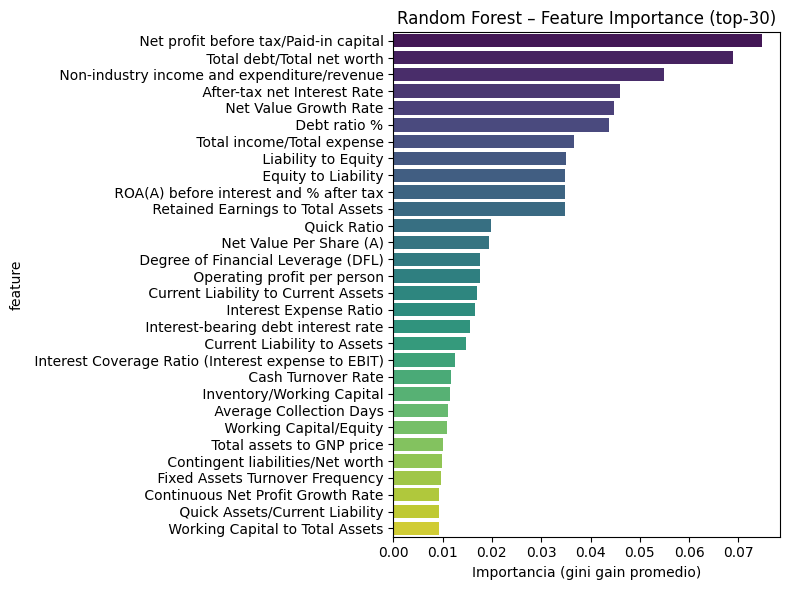

C:\Users\danie\AppData\Local\Temp\ipykernel_2676\1521601674.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.tail(20),


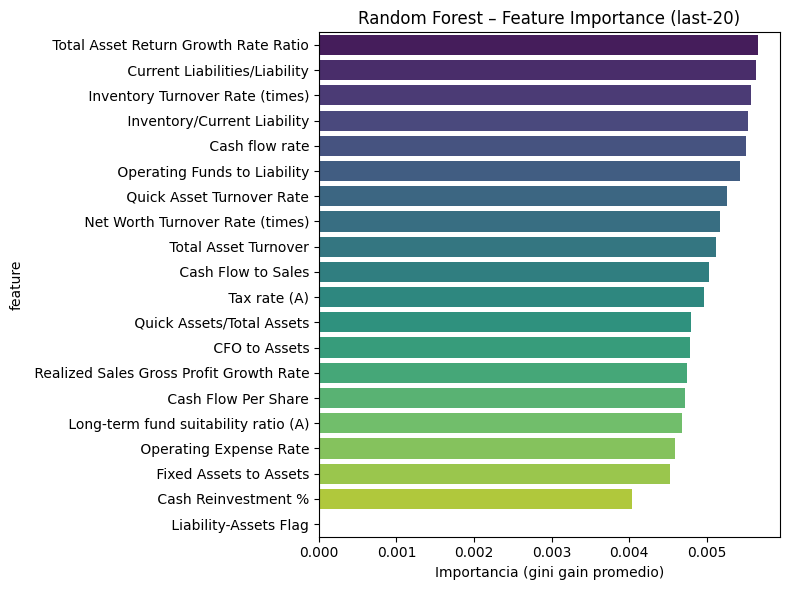

In [64]:

importancias = best_rf_model.feature_importances_
feat_names  = X_train_smote_0_2.columns  
feat_imp_df = pd.DataFrame({"feature": feat_names,
                            "importance": importancias})
feat_imp_df = feat_imp_df.sort_values(by="importance", ascending=False)


plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp_df.head(30),
            x="importance", y="feature",
            palette="viridis")
plt.title("Random Forest – Feature Importance (top-30)")
plt.xlabel("Importancia (gini gain promedio)")
plt.tight_layout()
plt.show();

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp_df.tail(20),
            x="importance", y="feature",
            palette="viridis")
plt.title("Random Forest – Feature Importance (last-20)")
plt.xlabel("Importancia (gini gain promedio)")
plt.tight_layout()
plt.show();

### RandomForest quitando feature importance menos importantes

In [80]:
feat_imp_df.head(10)

,feature,importance
27,Net profit before tax/Paid-in capital,0.074687
23,Total debt/Total net worth,0.068898
3,Non-industry income and expenditure/revenue,0.054798
2,After-tax net Interest Rate,0.046074
17,Net Value Growth Rate,0.044715
24,Debt ratio %,0.043786
52,Total income/Total expense,0.036564
66,Liability to Equity,0.035080
69,Equity to Liability,0.034884
0,ROA(A) before interest and % after tax,0.034812


In [92]:
feat_imp_df.iloc[-25:]

,feature,importance
11,Revenue Per Share (Yuan ¥),0.006058
65,No-credit Interval,0.005893
60,Cash Flow to Total Assets,0.005843
54,Current Asset Turnover Rate,0.005744
28,Inventory and accounts receivable/Net value,0.005706
18,Total Asset Return Growth Rate Ratio,0.005660
48,Current Liabilities/Liability,0.005628
32,Inventory Turnover Rate (times),0.005574
47,Inventory/Current Liability,0.005532
6,Cash flow rate,0.005503


In [8]:
df.columns

Index(['bankrupt', 'roaa_before_interest_and_percent_after_tax',
       'operating_gross_margin', 'after_tax_net_interest_rate',
       'non_industry_income_and_expenditure_revenue', 'operating_expense_rate',
       'research_and_development_expense_rate', 'cash_flow_rate',
       'interest_bearing_debt_interest_rate', 'tax_rate_a',
       'net_value_per_share_a', 'cash_flow_per_share',
       'revenue_per_share_yuan', 'realized_sales_gross_profit_growth_rate',
       'operating_profit_growth_rate', 'regular_net_profit_growth_rate',
       'continuous_net_profit_growth_rate', 'total_asset_growth_rate',
       'net_value_growth_rate', 'total_asset_return_growth_rate_ratio',
       'cash_reinvestment_percent', 'current_ratio', 'quick_ratio',
       'interest_expense_ratio', 'total_debt_total_net_worth',
       'debt_ratio_percent', 'long_term_fund_suitability_ratio_a',
       'contingent_liabilities_net_worth',
       'net_profit_before_tax_paid_in_capital',
       'inventory_and_account

In [18]:
X2 = df.drop(columns=["bankrupt","long_term_fund_suitability_ratio_a", 
                      "operating_expense_rate", "fixed_assets_to_assets", "cash_reinvestment_percent",
                        "liability_assets_flag",
                        
                      ])
y2 = df["bankrupt"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=10, stratify=y2)

In [10]:
# Actualizar Xtrain
X_train2.to_csv('../data/train/X_train.csv', index=False)
y_train2.to_csv('../data/train/y_train.csv', index=False)
X_test2.to_csv('../data/test/X_test.csv', index=False)
y_test2.to_csv('../data/test/y_test.csv', index=False)

In [19]:
# Balance con SMOTE strategy 0.25
print("\n--- Estrategia: SMOTE con sampling_strategy=0.25 ---")
smote2 = SMOTE(random_state=42, sampling_strategy=0.25) # Clase minoritaria = 20% de la mayoritaria
X_train_smote2, y_train_smote2 = smote2.fit_resample(X_train2, y_train2)
print("Conteo de clases después de SMOTE (0.25):")
print(y_train_smote2.value_counts())



--- Estrategia: SMOTE con sampling_strategy=0.25 ---
Conteo de clases después de SMOTE (0.25):
bankrupt
0    5279
1    1319
Name: count, dtype: int64


### Mejor resultado RandomForest

In [20]:
rf_smote2 = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf= 1,
    min_samples_split=2,
)
rf_smote2.fit(X_train_smote2, y_train_smote2)
y_pred_smote2 = rf_smote2.predict(X_test2)
y_proba_smote2 = rf_smote2.predict_proba(X_test2)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test2, y_pred_smote2))
print("\nClassification Report:\n", classification_report(y_test2, y_pred_smote2))
print("ROC AUC:", roc_auc_score(y_test2, y_proba_smote2))

Confusion Matrix:
 [[1301   19]
 [  28   16]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.46      0.36      0.41        44

    accuracy                           0.97      1364
   macro avg       0.72      0.67      0.69      1364
weighted avg       0.96      0.97      0.96      1364

ROC AUC: 0.9216253443526172


In [21]:
param_grid_rf2 = {
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "n_estimators": [800,2000,] 
}
# Inicializa el GridSearchCV
grid_rf2 = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf2,
    scoring="recall",
    cv=5, # Number of cross-validation folds
    n_jobs=-1 
)


num_combinations = 1
for values in param_grid_rf2.values():
    num_combinations *= len(values)

total_iterations = num_combinations * grid_rf2.cv

print(f"Número total de combinaciones de parámetros: {num_combinations}")
print(f"Número de folds de CV: {grid_rf2.cv}")
print(f"Total de trabajos a realizar: {total_iterations}")


print("\nIniciando GridSearchCV con barra de progreso...")
with tqdm_joblib(tqdm(desc="GridSearchCV", total=total_iterations)):
    grid_rf2.fit(X_train_smote2, y_train_smote2) 

print("\n--- GridSearchCV Completado ---")
print("Mejores parámetros para RandomForest (con Smote):")
print(grid_rf2.best_params_)
best_rf_model2 = grid_rf2.best_estimator_

# Evaluar best_rf_model
y_pred_best_rf2 = best_rf_model2.predict(X_test2)
y_proba_best_rf2 = best_rf_model2.predict_proba(X_test2)[:, 1]

print("\nConfusion Matrix (Best RF):\n", confusion_matrix(y_test2, y_pred_best_rf2))
print("\nClassification Report (Best RF):\n", classification_report(y_test2, y_pred_best_rf2))
print("\nROC AUC (Best RF):", roc_auc_score(y_test2, y_proba_best_rf2))

Número total de combinaciones de parámetros: 2
Número de folds de CV: 5
Total de trabajos a realizar: 10

Iniciando GridSearchCV con barra de progreso...


GridSearchCV:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


--- GridSearchCV Completado ---
Mejores parámetros para RandomForest (con Smote):
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}

Confusion Matrix (Best RF):
 [[1302   18]
 [  28   16]]

Classification Report (Best RF):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.47      0.36      0.41        44

    accuracy                           0.97      1364
   macro avg       0.72      0.68      0.70      1364
weighted avg       0.96      0.97      0.96      1364


ROC AUC (Best RF): 0.9208849862258953


In [22]:
best_rf_model2

RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42)

In [23]:
models_dir = '../models'
model_filename = 'final_model_randomforest.pkl' 
full_path = os.path.join(models_dir, model_filename)

# Crea la carpeta 'models' si no existe 
os.makedirs(models_dir, exist_ok=True)

# Guarda el modelo usando pickle
try:
    with open(full_path, 'wb') as file: # 'wb' significa 'write binary' (escribir en modo binario)
        pickle.dump(best_rf_model2, file)
    print(f"Tu mejor modelo Random Forest ha sido guardado exitosamente (con pickle) en: {full_path}")
except Exception as e:
    print(f"Error al guardar el modelo Random Forest (con pickle): {e}")

# Opcional: Para verificar que se guardó correctamente, puedes intentar cargarlo
try:
     with open(full_path, 'rb') as file: # 'rb' significa 'read binary' (leer en modo binario)
         loaded_rf_model = pickle.load(file)
     print(f"Modelo Random Forest cargado (con pickle) y listo para usar: {type(loaded_rf_model)}")
except Exception as e:
     print(f"Error al cargar el modelo Random Forest (con pickle): {e}")

Tu mejor modelo Random Forest ha sido guardado exitosamente (con pickle) en: ../models\final_model_randomforest.pkl
Modelo Random Forest cargado (con pickle) y listo para usar: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [24]:
models_dir = '../models'
model_filename = 'final_model_randomforest.pkl' 
full_path = os.path.join(models_dir, model_filename)
try:
     with open(full_path, 'rb') as file: # 'rb' significa 'read binary' (leer en modo binario)
         loaded_rf_model = pickle.load(file)
     print(f"Modelo Random Forest cargado (con pickle) y listo para usar: {type(loaded_rf_model)}")
except Exception as e:
     print(f"Error al cargar el modelo Random Forest (con pickle): {e}")


Modelo Random Forest cargado (con pickle) y listo para usar: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [25]:
loaded_rf_model

RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42)

### Random Forest sin SMOTE, class weight=Balanced

In [ ]:

param_grid_rf = {
    "max_depth": [None,20,50,100],
    "min_samples_split": [2,4,20],
    "min_samples_leaf": [1,2],
    "n_estimators": [500,600],
    "class_weight":["balanced"]  # Sin SMOTE
}
# Inicializa el GridSearchCV
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    scoring="recall",
    cv=5, # Number of cross-validation folds
    n_jobs=-1 
)


num_combinations = 1
for values in param_grid_rf.values():
    num_combinations *= len(values)

total_iterations = num_combinations * grid_rf.cv

print(f"Número total de combinaciones de parámetros: {num_combinations}")
print(f"Número de folds de CV: {grid_rf.cv}")
print(f"Total de trabajos a realizar: {total_iterations}")


print("\nIniciando GridSearchCV con barra de progreso...")
with tqdm_joblib(tqdm(desc="GridSearchCV", total=total_iterations)):
    grid_rf.fit(X_train, y_train) 

print("\n--- GridSearchCV Completado ---")
print("Mejores parámetros para RandomForest (con class_weight='balanced'):")
print(grid_rf.best_params_)
best_rf_model = grid_rf.best_estimator_

# Evaluar best_rf_model
y_pred_best_rf = best_rf_model.predict(X_test)
y_proba_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix (Best RF):\n", confusion_matrix(y_test, y_pred_best_rf))
print("\nClassification Report (Best RF):\n", classification_report(y_test, y_pred_best_rf))
print("\nROC AUC (Best RF):", roc_auc_score(y_test, y_proba_best_rf))

Número total de combinaciones de parámetros: 48
Número de folds de CV: 5
Total de trabajos a realizar: 240

Iniciando GridSearchCV con barra de progreso...


  0%|          | 0/240 [00:00<?, ?it/s]


--- GridSearchCV Completado ---
Mejores parámetros para RandomForest (con Smote):
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500}

Confusion Matrix (Best RF):
 [[1309   11]
 [  33   11]]

Classification Report (Best RF):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.50      0.25      0.33        44

    accuracy                           0.97      1364
   macro avg       0.74      0.62      0.66      1364
weighted avg       0.96      0.97      0.96      1364


ROC AUC (Best RF): 0.9108126721763087


## GridSearch y creación de distintos Modelos

In [ ]:
def run_gridsearch_with_tqdm(model, param_grid, X_train_data, y_train_data, scoring_metric, cv_folds=5, model_name="Modelo"):
    """
    Ejecuta GridSearchCV con una barra de progreso de tqdm.
    """
    grid_search = GridSearchCV(
        model,
        param_grid,
        scoring=scoring_metric,
        cv=cv_folds,
        n_jobs=-1
    )

    # Calcular el número total de iteraciones para la barra de progreso
    num_combinations = 1
    for values in param_grid.values():
        num_combinations *= len(values)
    total_iterations = num_combinations * cv_folds

    print(f"\n--- Iniciando GridSearchCV para {model_name} (Total iteraciones: {total_iterations}) ---")
    with tqdm_joblib(tqdm(desc=f"GridSearchCV {model_name}", total=total_iterations)):
        grid_search.fit(X_train_data, y_train_data)

    print(f"\n--- GridSearchCV para {model_name} Completado ---")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Evaluar el mejor modelo
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

    print(f"\nConfusion Matrix ({model_name}):\n", confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report ({model_name}):\n", classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"ROC AUC ({model_name}):", roc_auc_score(y_test, y_proba))

    return best_model, grid_search.best_params_


results = [] 

ada_model = AdaBoostClassifier(random_state=42)
param_grid_ada = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5, 1.0, 1.5]
}
best_ada, best_params_ada = run_gridsearch_with_tqdm(
    ada_model, param_grid_ada, X_train_smote_0_2, y_train_smote_0_2,
    scoring_metric="recall", model_name="AdaBoost"
)
results.append({"model": "AdaBoost", "best_params": best_params_ada,
                "recall": recall_score(y_test, best_ada.predict(X_test))})
joblib.dump(best_ada, '../models/final_model_adaboost.pkl')


# 2. GradientBoosting
# %% [markdown]
# ### GridSearchCV para GradientBoosting
# %%
gb_model = GradientBoostingClassifier(random_state=42)
param_grid_gb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}
best_gb, best_params_gb = run_gridsearch_with_tqdm(
    gb_model, param_grid_gb, X_train_smote_0_2, y_train_smote_0_2,
    scoring_metric="recall", model_name="GradientBoosting"
)
results.append({"model": "GradientBoosting", "best_params": best_params_gb,
                "recall": recall_score(y_test, best_gb.predict(X_test))})
joblib.dump(best_gb, '../models/final_model_gradientboosting.pkl')


# 3. XGBoost
# %% [markdown]
# ### GridSearchCV para XGBoost
# %%
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False, n_jobs=-1)
param_grid_xgb = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}
best_xgb, best_params_xgb = run_gridsearch_with_tqdm(
    xgb_model, param_grid_xgb, X_train_smote_0_2, y_train_smote_0_2,
    scoring_metric="recall", model_name="XGBoost"
)
results.append({"model": "XGBoost", "best_params": best_xgb,
                "recall": recall_score(y_test, best_xgb.predict(X_test))}) # Corregido best_xgb a best_xgb.predict
joblib.dump(best_xgb, '../models/final_model_xgboost.pkl')


# 4. LightGBM
# %% [markdown]
# ### GridSearchCV para LightGBM
# %%
lgbm_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)
param_grid_lgbm = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "num_leaves": [20, 31, 40],
    "max_depth": [5, 7, -1],
}
best_lgbm, best_params_lgbm = run_gridsearch_with_tqdm(
    lgbm_model, param_grid_lgbm, X_train_smote_0_2, y_train_smote_0_2,
    scoring_metric="recall", model_name="LightGBM"
)
results.append({"model": "LightGBM", "best_params": best_params_lgbm,
                "recall": recall_score(y_test, best_lgbm.predict(X_test))})
joblib.dump(best_lgbm, '../models/final_model_lightgbm.pkl')


# --- Resumen de Resultados ---
print("\n--- Resumen de los mejores modelos encontrados (por recall en el test set) ---")
for res in results:
    print(f"Modelo: {res['model']}")
    print(f"  Mejores Parámetros: {res['best_params']}")
    print(f"  Recall en Test: {res['recall']:.4f}\n")


df_results_summary = pd.DataFrame(results)
print("\nDataFrame Resumen:")
print(df_results_summary.sort_values(by="recall", ascending=False))

GridSearchCV:   0%|          | 0/360 [10:07<?, ?it/s]



--- Iniciando GridSearchCV para AdaBoost (Total iteraciones: 100) ---


GridSearchCV AdaBoost:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--- GridSearchCV para AdaBoost Completado ---
Mejores parámetros: {'learning_rate': 1.0, 'n_estimators': 300}

Confusion Matrix (AdaBoost):
 [[1298   22]
 [  30   14]]

Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.39      0.32      0.35        44

    accuracy                           0.96      1364
   macro avg       0.68      0.65      0.67      1364
weighted avg       0.96      0.96      0.96      1364

ROC AUC (AdaBoost): 0.8263774104683195


GridSearchCV AdaBoost:   0%|          | 0/100 [01:46<?, ?it/s]



--- Iniciando GridSearchCV para GradientBoosting (Total iteraciones: 135) ---


GridSearchCV GradientBoosting:   0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

GridSearchCV GradientBoosting:   0%|          | 0/135 [10:44<?, ?it/s]



--- GridSearchCV para GradientBoosting Completado ---
Mejores parámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}

Confusion Matrix (GradientBoosting):
 [[1305   15]
 [  29   15]]

Classification Report (GradientBoosting):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.50      0.34      0.41        44

    accuracy                           0.97      1364
   macro avg       0.74      0.66      0.69      1364
weighted avg       0.96      0.97      0.96      1364

ROC AUC (GradientBoosting): 0.9159607438016529

--- Iniciando GridSearchCV para XGBoost (Total iteraciones: 135) ---


GridSearchCV XGBoost:   0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:30:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- GridSearchCV para XGBoost Completado ---
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

Confusion Matrix (XGBoost):
 [[1308   12]
 [  30   14]]

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.54      0.32      0.40        44

    accuracy                           0.97      1364
   macro avg       0.76      0.65      0.69      1364
weighted avg       0.96      0.97      0.97      1364

ROC AUC (XGBoost): 0.9171315426997245

--- Iniciando GridSearchCV para LightGBM (Total iteraciones: 405) ---


  0%|          | 0/405 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1055, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17594
[LightGBM] [Info] Number of data points in the train set: 6334, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166561 -> initscore=-1.610196
[LightGBM] [Info] Start training from score -1.610196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [24]:
df_results_summary

,model,best_params,recall
0,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 300}",0.318182
1,GradientBoosting,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.340909
2,XGBoost,"XGBClassifier(base_score=None, booster=None, c...",0.318182
3,LightGBM,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",0.272727


In [23]:
os.makedirs('../reports', exist_ok=True)
df_results_summary.to_csv('../reports/model_comparison_results.csv', index=False)
print("\nResultados de la comparación de modelos guardados en ../reports/model_comparison_results.csv")


Resultados de la comparación de modelos guardados en ../reports/model_comparison_results.csv


### Modelo No supervisado: PCA + KMeans

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print(f"\n--- Iniciando Transformación PCA sobre X2 (n_components: 0.95) ---")
pca_model_req = PCA(n_components=0.95, random_state=42)
X2_pca = pca_model_req.fit_transform(X2)

# Guardar el modelo PCA
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)
pca_model_path = os.path.join(models_dir, 'pca_model.pkl') 
try:
    with open(pca_model_path, 'wb') as f:
        pickle.dump(pca_model_req, f)
    print(f"Modelo PCA guardado exitosamente en: {pca_model_path}")
except Exception as e:
    print(f"Error al guardar el modelo PCA: {e}")

print(f"PCA completado. Número de componentes finales: {pca_model_req.n_components_}")
print(f"Varianza explicada acumulada: {pca_model_req.explained_variance_ratio_.sum():.4f}")
print(f"Shape de X2 después de PCA: {X2_pca.shape}")

n_final_components_pca = pca_model_req.n_components_
X2_pca_df = pd.DataFrame(X2_pca, index=X2.index, columns=[f'pca_comp_{i}' for i in range(n_final_components_pca)])


# --- Paso 2: KMeans para Clustering ---
# Aplicar KMeans sobre los datos transformados por PCA

print(f"\n--- Iniciando Clustering KMeans sobre X2_pca_df (n_clusters: 3) ---")
kmeans_model_req = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_model_req.fit(X2_pca_df)

# Guardar el modelo KMeans
kmeans_model_path = os.path.join(models_dir, 'kmeans_model.pkl') # Usa un nombre diferente si ya tienes uno en tu pipeline
try:
    with open(kmeans_model_path, 'wb') as f:
        pickle.dump(kmeans_model_req, f)
    print(f"Modelo KMeans guardado exitosamente en: {kmeans_model_path}")
except Exception as e:
    print(f"Error al guardar el modelo KMeans: {e}")

print("Clustering KMeans completado.")
# Añadir las etiquetas de cluster a un DataFrame si quieres inspeccionarlas
X2_clustered = X2_pca_df.copy() 
X2_clustered['cluster_label'] = kmeans_model_req.predict(X2_pca_df)
print(f"Conteo de clusters en X2:\n{X2_clustered['cluster_label'].value_counts()}")


print("\n--- Modelos no supervisados (PCA y KMeans) guardado ---")


--- Iniciando Transformación PCA sobre X2 (n_components: 0.95) ---
Modelo PCA guardado exitosamente en: ../models\pca_model.pkl
PCA completado. Número de componentes finales: 7
Varianza explicada acumulada: 0.9991
Shape de X2 después de PCA: (6819, 7)

--- Iniciando Clustering KMeans sobre X2_pca_df (n_clusters: 3) ---
Modelo KMeans guardado exitosamente en: ../models\kmeans_model.pkl
Clustering KMeans completado.
Conteo de clusters en X2:
cluster_label
1    3376
2    1791
0    1652
Name: count, dtype: int64

--- Modelos no supervisados (PCA y KMeans) guardado ---
